## **MultiRes UNet - Colab Pro with 256*256 dimensions**

### **MultiRes - Filters as mentioned in the base paper**
* Used 500 images of dimensions: (width = 256, height = 256)
* Filters tried: As mentioned in our base paper. 

### **MultiRes - Original Filters**
* Used 1500 images of dimensions: (width = 256, height = 256)
* In the model defined below, the filters applied are: 32, 64, 128, 256.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
# from keras_unet.utils import get_patches
# from keras_unet.models import satellite_unet
import glob
import os
from keras import backend as K 
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from keras.models import Model, model_from_json, load_model
import torch
from tensorflow.keras.optimizers import Adam
# from tensorflow import keras
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
print(torch.cuda.is_available())

%matplotlib inline

True


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Feb  6 09:23:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [53]:
train_image_paths_list = []
train_gt_paths_list = []
train_image_path = '/content/drive/MyDrive/airs-minisample/patch-png/train_images/train/'
train_label_path = '/content/drive/MyDrive/airs-minisample/patch-png/train_masks/train/'

for img_path in glob.glob(os.path.join(train_image_path, '*.png')):
    train_image_paths_list.append(str(img_path))   
print("Total aerial satellite images : ",len(train_image_paths_list))

for img_path in glob.glob(os.path.join(train_label_path, '*.png')):
    train_gt_paths_list.append(str(img_path))
print("Total segmented mask images : ",len(train_gt_paths_list))

train_image_paths_list.sort()
train_gt_paths_list.sort()

Total aerial satellite images :  1548
Total segmented mask images :  1548


In [54]:
train_X = []
count = 0
for img in train_image_paths_list:
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    train_X.append(resized_img)

In [55]:
count = 0
train_Y = []
for img in train_gt_paths_list:
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    train_Y.append(resized_img)
    
print(len(train_X), len(train_Y))

1548 1548


In [56]:
val_image_paths_list = []
val_gt_paths_list = []
val_image_path = '/content/drive/MyDrive/airs-minisample/patch-png/val_images/val/'
val_label_path = '/content/drive/MyDrive/airs-minisample/patch-png/val_masks/val/'

for img_path in glob.glob(os.path.join(val_image_path, '*.png')):
    val_image_paths_list.append(str(img_path))        
print("Total aerial images in vaidation set : ",len(val_image_paths_list))

for img_path in glob.glob(os.path.join(val_label_path, '*.png')):
    val_gt_paths_list.append(str(img_path))        
print("Total segmented mask images in validation set : ",len(val_gt_paths_list))

val_image_paths_list.sort()
val_gt_paths_list.sort()

Total aerial images in vaidation set :  36
Total segmented mask images in validation set :  36


In [57]:
val_X = []
val_Y = []
for img in val_image_paths_list:
    # print(img)
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    val_X.append(resized_img)
    
for img in val_gt_paths_list:
    # print(img)
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    val_Y.append(resized_img)
    
print(len(val_X), len(val_Y))

36 36


In [48]:
test_image_paths_list = []
test_gt_paths_list = []
test_image_path = '/content/drive/MyDrive/airs-minisample/patch-png/test_images/test/'
test_label_path = '/content/drive/MyDrive/airs-minisample/patch-png/test_masks/test/'

for img_path in glob.glob(os.path.join(test_image_path, '*.png')):
    test_image_paths_list.append(str(img_path))        
print("Total aerial images in vaidation set : ",len(test_image_paths_list))

for img_path in glob.glob(os.path.join(test_label_path, '*.png')):
    test_gt_paths_list.append(str(img_path))        
print("Total segmented mask images in validation set : ",len(test_gt_paths_list))

test_image_paths_list.sort()
test_gt_paths_list.sort()

Total aerial images in vaidation set :  36
Total segmented mask images in validation set :  36


In [49]:
test_X = []
test_Y = []
for img in test_image_paths_list:
    # print(img)
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    test_X.append(resized_img)
    
for img in test_gt_paths_list:
    # print(img)
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    test_Y.append(resized_img)
    
print(len(test_X), len(test_Y))

36 36


**With min_max scaler**

In [58]:
scaler = MinMaxScaler()
train_X = np.array(train_X)
train_Y = np.array(train_Y)

train_Y = train_Y.reshape((train_Y.shape[0],train_Y.shape[1],train_Y.shape[2],1))

scaler = MinMaxScaler()
train_X_scaler = scaler.fit_transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape)
train_Y_scaler = scaler.fit_transform(train_Y.reshape(-1, train_Y.shape[-1])).reshape(train_Y.shape)
print(train_X_scaler.shape, train_Y_scaler.shape)

(1548, 256, 256, 3) (1548, 256, 256, 1)


In [59]:
val_X = np.array(val_X)
val_Y = np.array(val_Y)

val_Y = val_Y.reshape((val_Y.shape[0],val_Y.shape[1],val_Y.shape[2],1))

val_X = scaler.fit_transform(val_X.reshape(-1, val_X.shape[-1])).reshape(val_X.shape)
val_Y = scaler.fit_transform(val_Y.reshape(-1, val_Y.shape[-1])).reshape(val_Y.shape)
# val_X = val_X / 255.
# val_Y = val_Y / 255.

print(val_X.shape)
print(val_Y.shape)

(36, 256, 256, 3)
(36, 256, 256, 1)


In [50]:
scaler = MinMaxScaler()
test_X = np.array(test_X)
test_Y = np.array(test_Y)

test_Y = test_Y.reshape((test_Y.shape[0], test_Y.shape[1], test_Y.shape[2],1))

test_X = scaler.fit_transform(test_X.reshape(-1, test_X.shape[-1])).reshape(test_X.shape)
test_Y = scaler.fit_transform(test_Y.reshape(-1, test_Y.shape[-1])).reshape(test_Y.shape)
# val_X = val_X / 255.
# val_Y = val_Y / 255.

print(test_X.shape)
print(test_Y.shape)

(36, 256, 256, 3)
(36, 256, 256, 1)


Text(0.5, 1.0, 'Original')

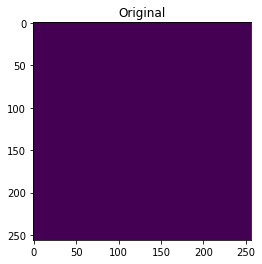

In [51]:
plt.imshow(np.squeeze(test_Y[0]))
plt.title('Original')

In [32]:
def IOU(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def dice_coef(y_true, y_pred):
    smooth = 0.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def mcc(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0) * 1e2  # needs to be checked
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0) / 1e2

    up = tp*tn - fp*fn
    down = K.sqrt((tp+fp) * (tp+fn) * (tn+fp) * (tn+fn))

    mcc = up / (down + K.epsilon())
    mcc = tf.where(tf.math.is_nan(mcc), tf.zeros_like(mcc), mcc)
    return mcc

### **Model defined as per base paper - changed filters from original implementaion of MultiRes**

In [41]:
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    
    return x


def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block
    
    Arguments:
        U {int} -- Number of filters in a corrsponding UNet stage
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp

    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out


def ResPath(filters, length, inp):
    '''
    ResPath
    
    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''


    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out


def MultiResUnet(height, width, n_channels):
    '''
    MultiResUNet
    
    Arguments:
        height {int} -- height of image 
        width {int} -- width of image 
        n_channels {int} -- number of channels in image
    
    Returns:
        [keras model] -- MultiResUNet model
    '''


    inputs = Input((height, width, n_channels))

    mresblock1 = MultiResBlock(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(32*2, 4, mresblock1)

    mresblock2 = MultiResBlock(32*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(32*4, 3, mresblock2)

    mresblock3 = MultiResBlock(32*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(32*8, 2, mresblock3)

    mresblock4 = MultiResBlock(32*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(32*16, 1, mresblock4)

    mresblock5 = MultiResBlock(32*16, pool4)

    up6 = concatenate([Conv2DTranspose(
        32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(32*8, up6)

    up7 = concatenate([Conv2DTranspose(
        32*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(32*4, up7)

    up8 = concatenate([Conv2DTranspose(
        32*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(32*2, up8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(32, up9)

    conv10 = conv2d_bn(mresblock9, 1, 1, 1, activation='sigmoid')
    
    MultiResModel = Model(inputs=[inputs], outputs=[conv10])

    return MultiResModel

In [42]:
MultiResModel = MultiResUnet(height=256, width=256, n_channels=3)
MultiResModel.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_229 (Conv2D)            (None, 256, 256, 8)  216         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_341 (Batch  (None, 256, 256, 8)  24         ['conv2d_229[0][0]']             
 Normalization)                                                                                   
                                                                                            

In [ ]:
MultiResModel.compile(optimizer = Adam(lr=0.01), loss = 'binary_crossentropy', metrics = [IOU, mcc, dice_coef, 'accuracy'], run_eagerly = True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Check how to store callbacks as JSON (callbacks should store all performance metrics and loss for each epoch)
history = MultiResModel.fit(x = train_X_scaler[:500], y = train_Y_scaler[:500], validation_data = (val_X, val_Y), batch_size = 8, epochs = 50, verbose = 1)

Epoch 1/50
63/63 [==============================] - 45s 559ms/step - loss: 0.4415 - IOU: 0.2910 - mcc: 0.0072 - dice_coef: 0.4469 - accuracy: 0.8827 - val_loss: 749.8411 - val_IOU: 0.2607 - val_mcc: 1.0534e-05 - val_dice_coef: 0.4135 - val_accuracy: 0.2538
Epoch 2/50
63/63 [==============================] - 34s 538ms/step - loss: 0.3308 - IOU: 0.3232 - mcc: 0.0119 - dice_coef: 0.4857 - accuracy: 0.9157 - val_loss: 1.2406 - val_IOU: 0.0127 - val_mcc: 0.0030 - val_dice_coef: 0.0251 - val_accuracy: 0.7337
Epoch 3/50
63/63 [==============================] - 34s 539ms/step - loss: 0.2811 - IOU: 0.3427 - mcc: 0.0153 - dice_coef: 0.5081 - accuracy: 0.9302 - val_loss: 0.6261 - val_IOU: 0.0976 - val_mcc: 4.5867e-04 - val_dice_coef: 0.1779 - val_accuracy: 0.7337
Epoch 4/50
63/63 [==============================] - 34s 536ms/step - loss: 0.2710 - IOU: 0.3375 - mcc: 0.0184 - dice_coef: 0.5023 - accuracy: 0.9226 - val_loss: 0.6296 - val_IOU: 0.1029 - val_mcc: 0.0033 - val_dice_coef: 0.1866 - val_acc

### **Graph**

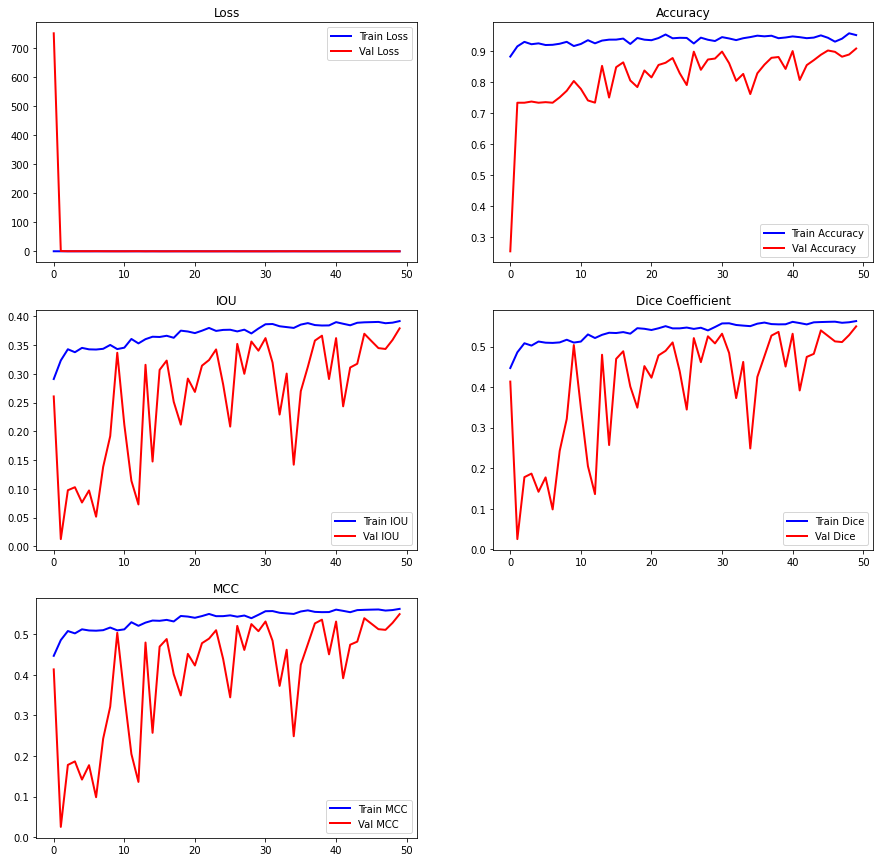

In [ ]:
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_acc = history.history['accuracy']
epoch_val_acc = history.history['val_accuracy']
epoch_jac = history.history['IOU']
epoch_val_jac = history.history['val_IOU']
epoch_dice = history.history['dice_coef']
epoch_val_dice = history.history['val_dice_coef']
epoch_mcc = history.history['mcc']
epoch_val_mcc = history.history['val_mcc']

# plt.figure(figsize=(20,6))
fig = plt.figure(figsize=(15,15))
plt.subplot(3,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Loss')
plt.legend(loc='best')

plt.subplot(3,2,2)
plt.plot(range(0,len(epoch_acc)), epoch_acc, 'b-', linewidth=2, label='Train Accuracy')
plt.plot(range(0,len(epoch_val_acc)), epoch_val_acc, 'r-', linewidth=2, label='Val Accuracy')
plt.title('Accuracy')
plt.legend(loc='best')

plt.subplot(3,2,3)
plt.plot(range(0,len(epoch_jac)), epoch_jac, 'b-', linewidth=2, label='Train IOU')
plt.plot(range(0,len(epoch_val_jac)), epoch_val_jac, 'r-', linewidth=2, label='Val IOU')
plt.title('IOU')
plt.legend(loc='best')

plt.subplot(3,2,4)
plt.plot(range(0,len(epoch_dice)), epoch_dice, 'b-', linewidth=2, label='Train Dice')
plt.plot(range(0,len(epoch_val_dice)), epoch_val_dice, 'r-', linewidth=2, label='Val Dice')
plt.title('Dice Coefficient')
plt.legend(loc='best')

plt.subplot(3,2,5)
plt.plot(range(0,len(epoch_mcc)), epoch_dice, 'b-', linewidth=2, label='Train MCC')
plt.plot(range(0,len(epoch_val_mcc)), epoch_val_dice, 'r-', linewidth=2, label='Val MCC')
plt.title('MCC')
plt.legend(loc='best')

plt.show()

### **Prediction on val image**

Image number: 0


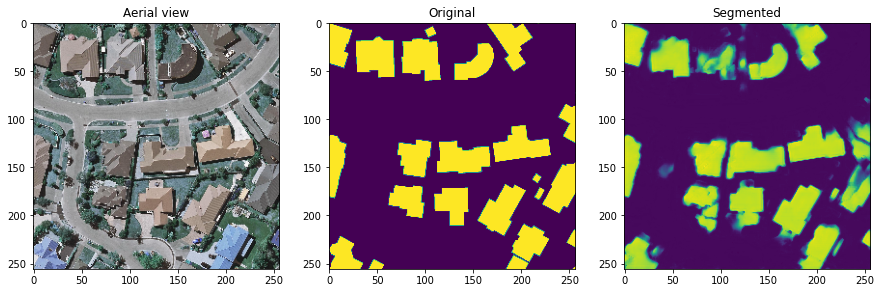

Image number: 1


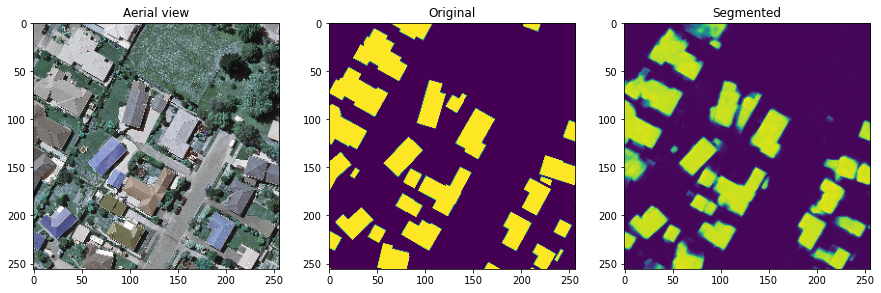

Image number: 2


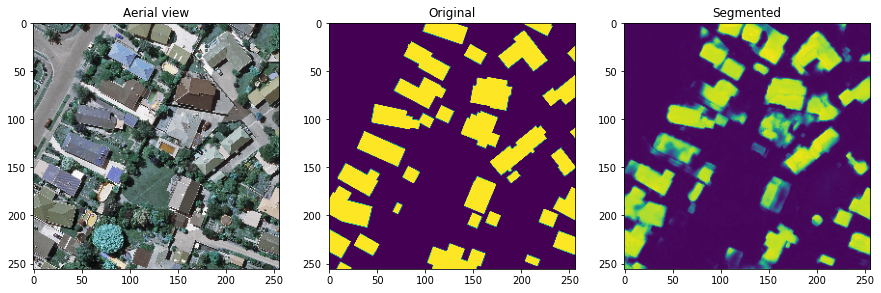

Image number: 3


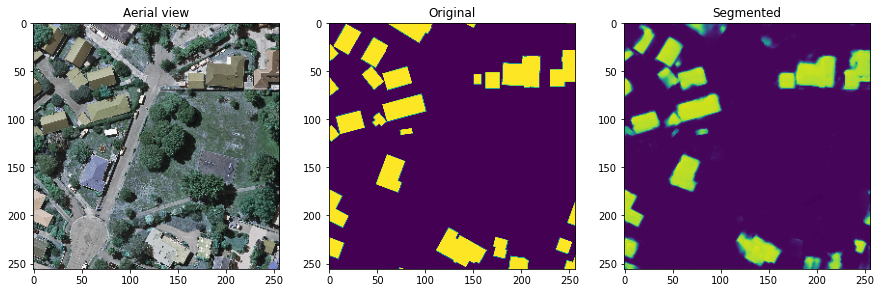

Image number: 4


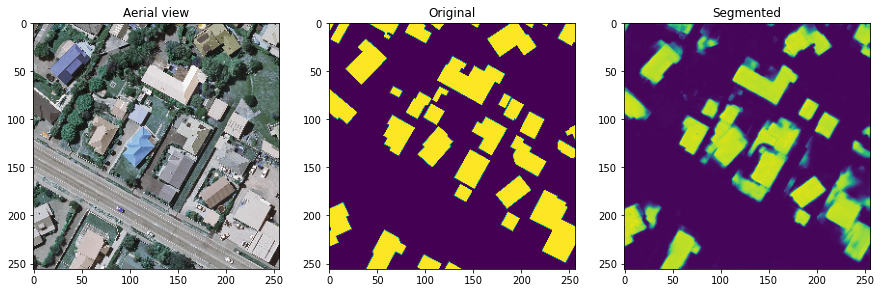

In [ ]:
rows = 6
columns = 3
count = 1
for image_number in range(0,5):

  fig = plt.figure(figsize=(15,15))
  print('Image number: {0}'.format(image_number))
  pred_y_MCC = MultiResModel.predict(val_X[image_number:image_number+1])
  pred_y_MCC = pred_y_MCC / 255.

  fig.add_subplot(rows, columns, count)
  plt.subplot(1,3,1)
  plt.imshow(np.squeeze(val_X[image_number:image_number+1]))
  plt.title('Aerial view')

  fig.add_subplot(rows, columns, count+1)
  plt.subplot(1,3,2)
  plt.imshow(np.squeeze(val_Y[image_number:image_number+1]))
  plt.title('Original')

  fig.add_subplot(rows, columns, count+2)
  plt.subplot(1,3,3)
  plt.imshow(np.squeeze(pred_y_MCC[0]))
  plt.title('Segmented')
  count += 3

  plt.show()

In [ ]:
MultiResModel.save_weights('/content/drive/MyDrive/airs-minisample/weights/multires-pro-500images-bp-50epochs.h5')
MultiResModel.save_weights('/content/drive/MyDrive/airs-minisample/weights/multires-pro-500images-bp-50epochs.tf')

### **Filters not as in BP but trying for 1500 images with validation**

In [60]:
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    
    return x


def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block
    
    Arguments:
        U {int} -- Number of filters in a corrsponding UNet stage
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp

    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out


def ResPath(filters, length, inp):
    '''
    ResPath
    
    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''


    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out


def MultiResUnet(height, width, n_channels):
    '''
    MultiResUNet
    
    Arguments:
        height {int} -- height of image 
        width {int} -- width of image 
        n_channels {int} -- number of channels in image
    
    Returns:
        [keras model] -- MultiResUNet model
    '''


    inputs = Input((height, width, n_channels))

    mresblock1 = MultiResBlock(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(32, 4, mresblock1)

    mresblock2 = MultiResBlock(32*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(32*2, 3, mresblock2)

    mresblock3 = MultiResBlock(32*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(32*4, 2, mresblock3)

    mresblock4 = MultiResBlock(32*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(32*8, 1, mresblock4)

    mresblock5 = MultiResBlock(32*16, pool4)

    up6 = concatenate([Conv2DTranspose(
        32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(32*8, up6)

    up7 = concatenate([Conv2DTranspose(
        32*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(32*4, up7)

    up8 = concatenate([Conv2DTranspose(
        32*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(32*2, up8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(32, up9)

    conv10 = conv2d_bn(mresblock9, 1, 1, 1, activation='sigmoid')
    
    MultiResModel = Model(inputs=[inputs], outputs=[conv10])

    return MultiResModel

In [61]:
MultiResModel_FiltersNotBP = MultiResUnet(height=256, width=256, n_channels=3)

In [62]:
MultiResModel_FiltersNotBP.compile(optimizer = Adam(lr=0.0001), loss = 'binary_crossentropy', metrics = [IOU, mcc, dice_coef, 'accuracy'], run_eagerly = True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [63]:
# Check how to store callbacks as JSON (callbacks should store all performance metrics and loss for each epoch)
history_2 = MultiResModel_FiltersNotBP.fit(x = train_X_scaler[:], y = train_Y_scaler[:], validation_data = (val_X, val_Y), batch_size = 4, epochs = 40, verbose = 1)

Epoch 1/40
387/387 [==============================] - 103s 261ms/step - loss: 0.5727 - IOU: 0.2052 - mcc: 0.0035 - dice_coef: 0.3331 - accuracy: 0.8289 - val_loss: 0.5886 - val_IOU: 0.1949 - val_mcc: 7.3722e-04 - val_dice_coef: 0.3260 - val_accuracy: 0.7453
Epoch 2/40
387/387 [==============================] - 100s 259ms/step - loss: 0.5206 - IOU: 0.2272 - mcc: 0.0044 - dice_coef: 0.3618 - accuracy: 0.8889 - val_loss: 0.4548 - val_IOU: 0.3744 - val_mcc: 0.0079 - val_dice_coef: 0.5445 - val_accuracy: 0.8977
Epoch 3/40
387/387 [==============================] - 100s 259ms/step - loss: 0.4969 - IOU: 0.2351 - mcc: 0.0047 - dice_coef: 0.3720 - accuracy: 0.9094 - val_loss: 0.4424 - val_IOU: 0.3835 - val_mcc: 0.0084 - val_dice_coef: 0.5540 - val_accuracy: 0.9040
Epoch 4/40
387/387 [==============================] - 100s 259ms/step - loss: 0.4801 - IOU: 0.2409 - mcc: 0.0050 - dice_coef: 0.3798 - accuracy: 0.9189 - val_loss: 0.4270 - val_IOU: 0.3996 - val_mcc: 0.0090 - val_dice_coef: 0.5707 - v

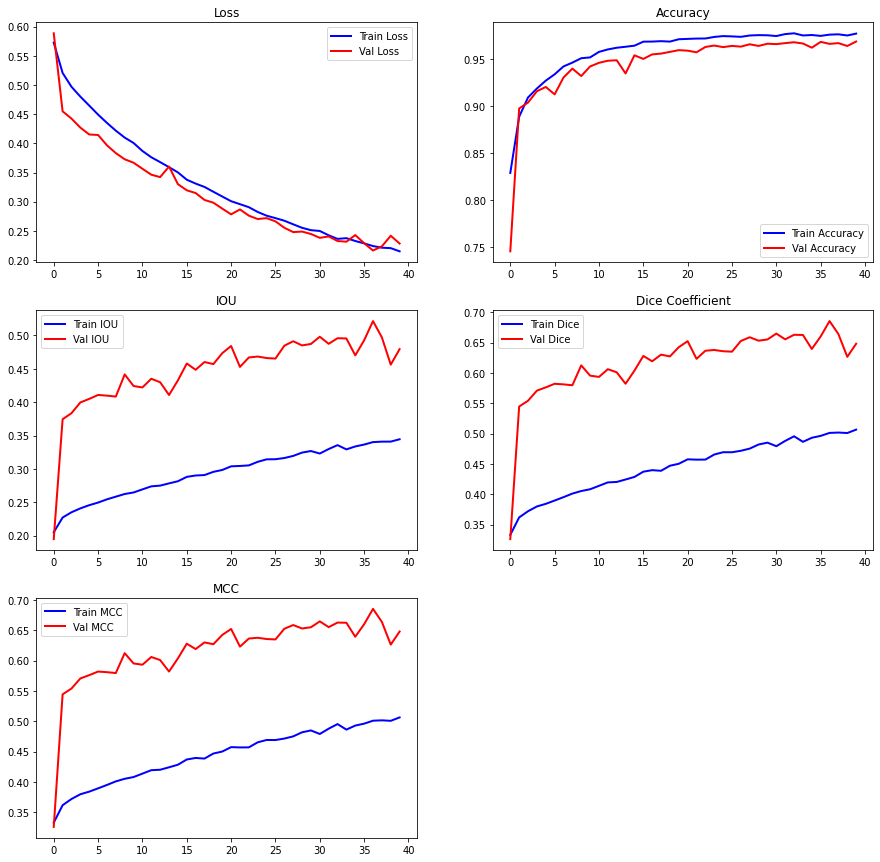

In [65]:
# Check how loss & mae went down
epoch_loss = history_2.history['loss']
epoch_val_loss = history_2.history['val_loss']
epoch_acc = history_2.history['accuracy']
epoch_val_acc = history_2.history['val_accuracy']
epoch_jac = history_2.history['IOU']
epoch_val_jac = history_2.history['val_IOU']
epoch_dice = history_2.history['dice_coef']
epoch_val_dice = history_2.history['val_dice_coef']
epoch_mcc = history_2.history['mcc']
epoch_val_mcc = history_2.history['val_mcc']

# plt.figure(figsize=(20,6))
fig = plt.figure(figsize=(15,15))
plt.subplot(3,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Loss')
plt.legend(loc='best')

plt.subplot(3,2,2)
plt.plot(range(0,len(epoch_acc)), epoch_acc, 'b-', linewidth=2, label='Train Accuracy')
plt.plot(range(0,len(epoch_val_acc)), epoch_val_acc, 'r-', linewidth=2, label='Val Accuracy')
plt.title('Accuracy')
plt.legend(loc='best')

plt.subplot(3,2,3)
plt.plot(range(0,len(epoch_jac)), epoch_jac, 'b-', linewidth=2, label='Train IOU')
plt.plot(range(0,len(epoch_val_jac)), epoch_val_jac, 'r-', linewidth=2, label='Val IOU')
plt.title('IOU')
plt.legend(loc='best')

plt.subplot(3,2,4)
plt.plot(range(0,len(epoch_dice)), epoch_dice, 'b-', linewidth=2, label='Train Dice')
plt.plot(range(0,len(epoch_val_dice)), epoch_val_dice, 'r-', linewidth=2, label='Val Dice')
plt.title('Dice Coefficient')
plt.legend(loc='best')

plt.subplot(3,2,5)
plt.plot(range(0,len(epoch_mcc)), epoch_dice, 'b-', linewidth=2, label='Train MCC')
plt.plot(range(0,len(epoch_val_mcc)), epoch_val_dice, 'r-', linewidth=2, label='Val MCC')
plt.title('MCC')
plt.legend(loc='best')

plt.show()

Image number: 0


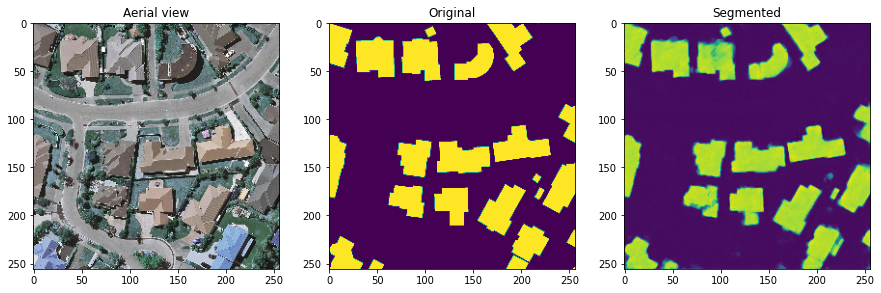

Image number: 1


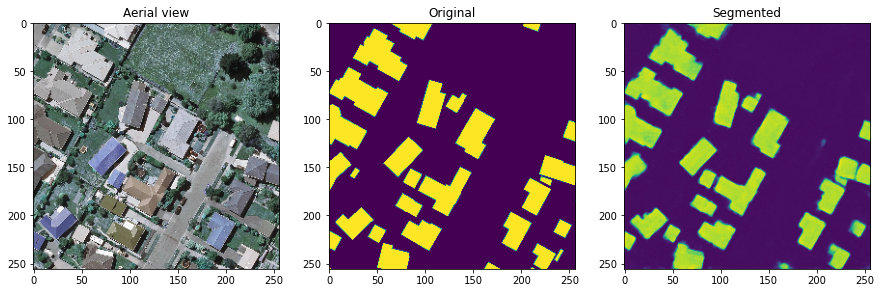

Image number: 2


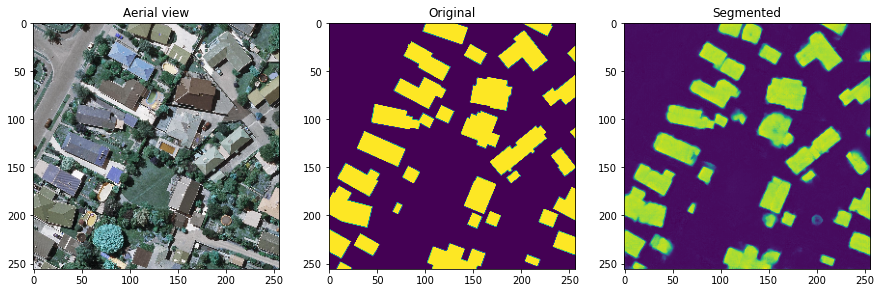

Image number: 3


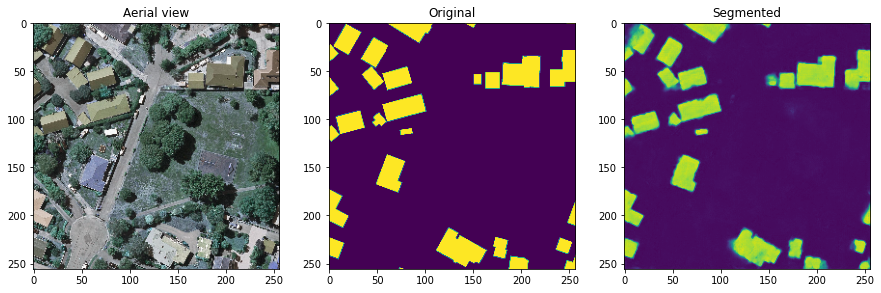

Image number: 4


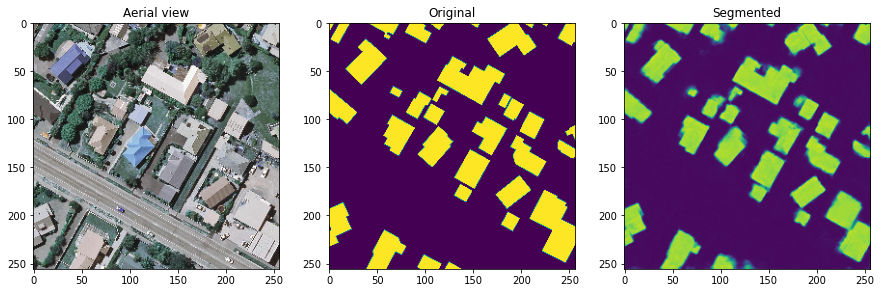

In [66]:
rows = 6
columns = 3
count = 1
for image_number in range(0,5):

  fig = plt.figure(figsize=(15,15))
  print('Image number: {0}'.format(image_number))
  pred_y_MCC = MultiResModel_FiltersNotBP.predict(val_X[image_number:image_number+1])
  pred_y_MCC = pred_y_MCC / 255.

  fig.add_subplot(rows, columns, count)
  plt.subplot(1,3,1)
  plt.imshow(np.squeeze(val_X[image_number:image_number+1]))
  plt.title('Aerial view')

  fig.add_subplot(rows, columns, count+1)
  plt.subplot(1,3,2)
  plt.imshow(np.squeeze(val_Y[image_number:image_number+1]))
  plt.title('Original')

  fig.add_subplot(rows, columns, count+2)
  plt.subplot(1,3,3)
  plt.imshow(np.squeeze(pred_y_MCC[0]))
  plt.title('Segmented')
  count += 3

  plt.show()

In [67]:
MultiResModel_FiltersNotBP.save_weights('/content/drive/MyDrive/airs-minisample/weights/multires-pro-allimages-40epochs.h5')
MultiResModel_FiltersNotBP.save_weights('/content/drive/MyDrive/airs-minisample/weights/multires-pro-allimages-40epochs.tf')

Image number: 0


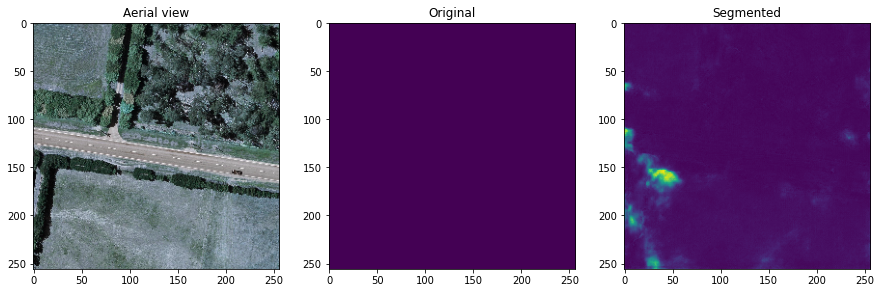

Image number: 1


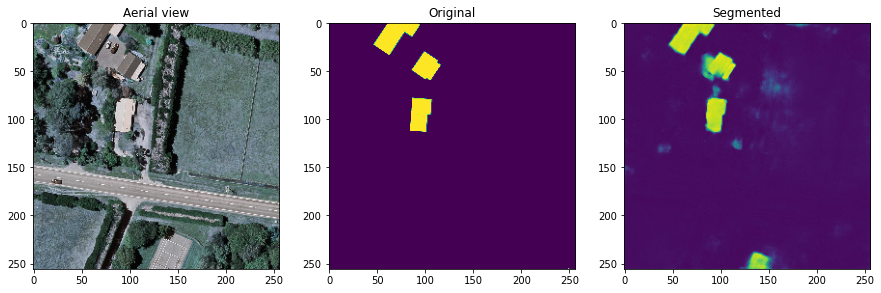

Image number: 2


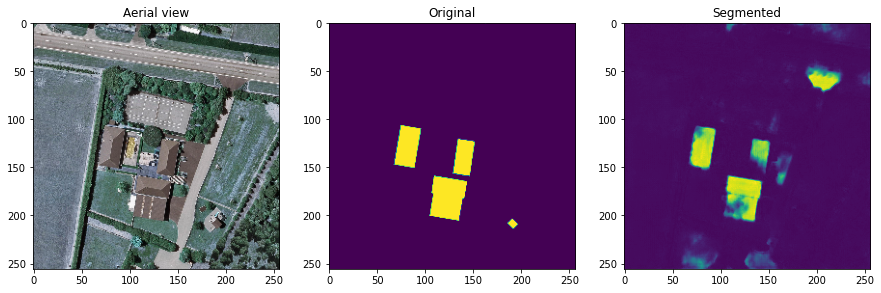

Image number: 3


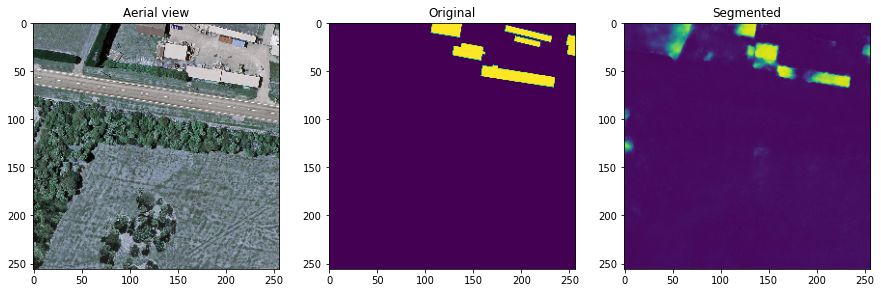

Image number: 4


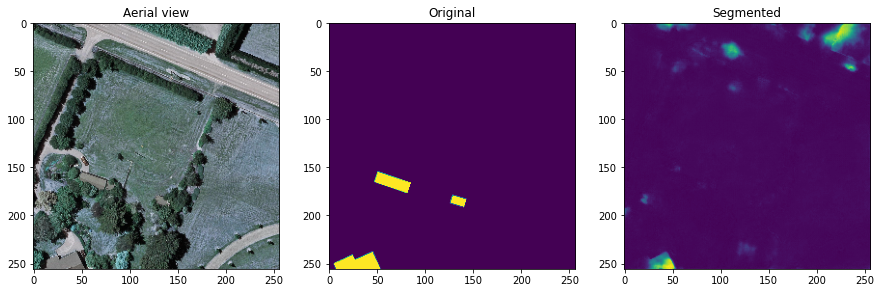

In [68]:
import tensorflow.keras as keras
rows = 6
columns = 3
count = 1
for image_number in range(0,5):

  fig = plt.figure(figsize=(15,15))
  print('Image number: {0}'.format(image_number))
  pred_y_MCC = MultiResModel_FiltersNotBP.predict(test_X[image_number:image_number+1])
  pred_y_MCC = pred_y_MCC / 255.

  fig.add_subplot(rows, columns, count)
  plt.subplot(1,3,1)
  plt.imshow(np.squeeze(test_X[image_number:image_number+1]))
  plt.title('Aerial view')

  fig.add_subplot(rows, columns, count+1)
  plt.subplot(1,3,2)
  plt.imshow(np.squeeze(test_Y[image_number:image_number+1]))
  plt.title('Original')

  fig.add_subplot(rows, columns, count+2)
  plt.subplot(1,3,3)
  plt.imshow(np.squeeze(pred_y_MCC[0]))
  plt.title('Segmented')
  count += 3

  plt.show()

In [73]:
from keras.models import load_model
MultiResModel_test = MultiResUnet(height = 256, width = 256, n_channels = 3)
MultiResModel_test.load_weights('/content/drive/MyDrive/airs-minisample/weights/multires-pro-allimages-40epochs.tf')

Image number: 0


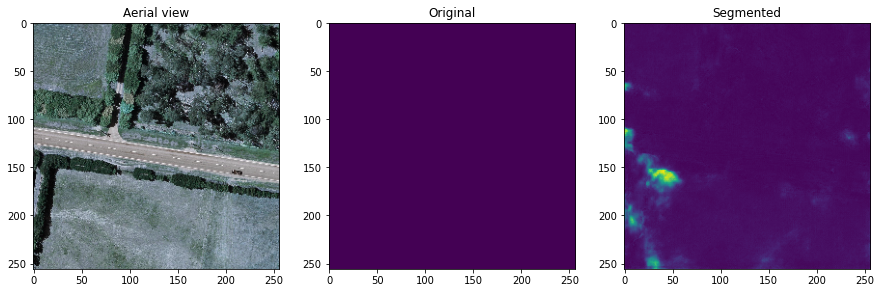

Image number: 1


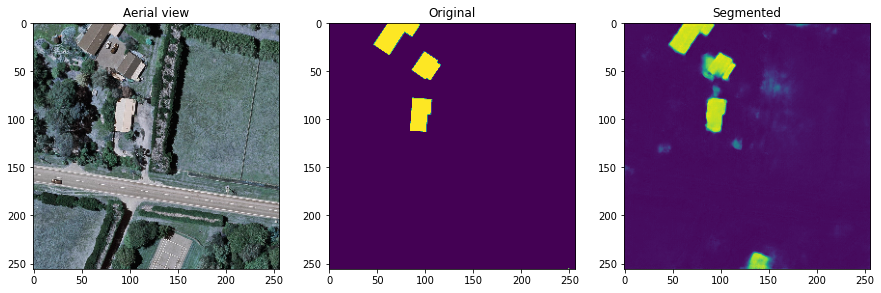

Image number: 2


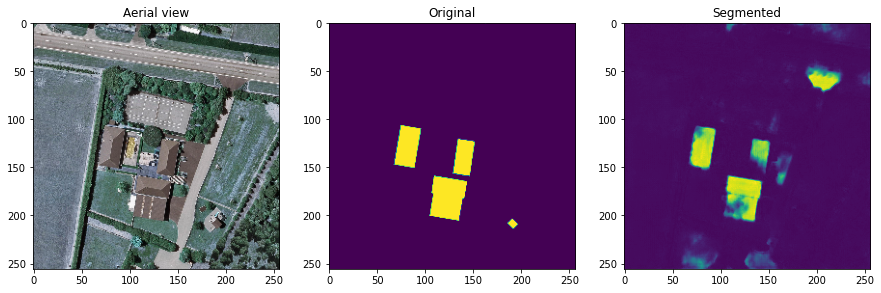

Image number: 3


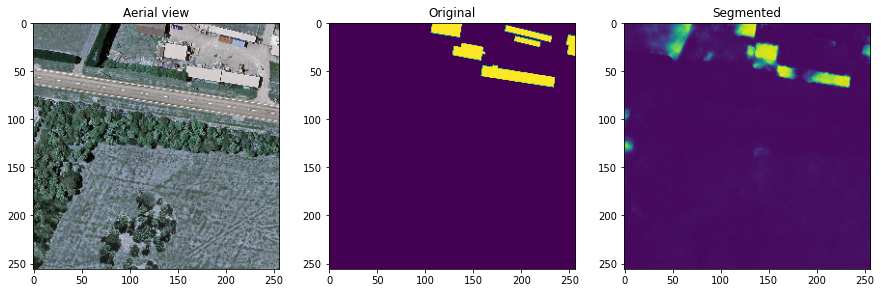

Image number: 4


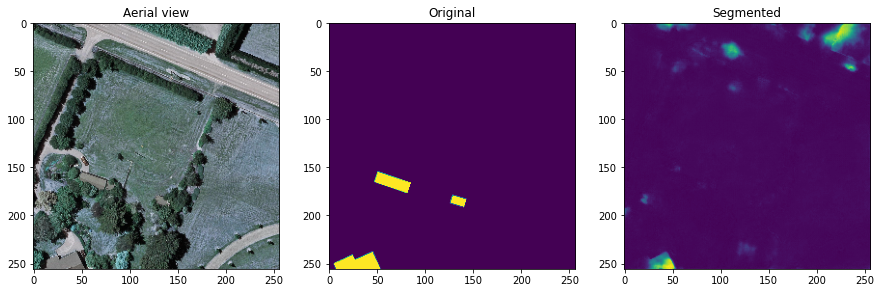

In [74]:
import tensorflow.keras as keras
rows = 6
columns = 3
count = 1
for image_number in range(0,5):

  fig = plt.figure(figsize=(15,15))
  print('Image number: {0}'.format(image_number))
  pred_y_MCC = MultiResModel_test.predict(test_X[image_number:image_number+1])
  pred_y_MCC = pred_y_MCC / 255.

  fig.add_subplot(rows, columns, count)
  plt.subplot(1,3,1)
  plt.imshow(np.squeeze(test_X[image_number:image_number+1]))
  plt.title('Aerial view')

  fig.add_subplot(rows, columns, count+1)
  plt.subplot(1,3,2)
  plt.imshow(np.squeeze(test_Y[image_number:image_number+1]))
  plt.title('Original')

  fig.add_subplot(rows, columns, count+2)
  plt.subplot(1,3,3)
  plt.imshow(np.squeeze(pred_y_MCC[0]))
  plt.title('Segmented')
  count += 3

  plt.show()

In [75]:
MultiResModel_test.evaluate(test_X, test_Y)

RuntimeError: ignored